In [1]:
import os
import pandas as pd 
import numpy as np
import imageio

import random
import shutil
from shutil import copyfile
import matplotlib.pyplot as plt
from collections import defaultdict


import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Split Data

In [21]:
def split_data(data_dir, train, val, test, train_size):
    """
    Inputs:The current data dir for a given class, the destination train, val and test dir. 
           PLus the ratio of train size.
    Output: Copies of the the images in the correct destination file locations.
    """
    #make list of of file names
    current_data = []
    for item in os.listdir(data_dir):
        if os.path.getsize(data_dir+item) >0:
            current_data.append(item)
        else:
            print(item, "Source is empty!")
    #shuffle the list of names
    shuff = random.sample(current_data, len(current_data))
    #split names into train, val and test
    size = int(len(current_data)*train_size)
    train_set = shuff[:size]
    val_test_set = shuff[size:]
    
    val_test_size = int(len(val_test_set) /2)
    val_set = val_test_set[:val_test_size]
    test_set = val_test_set[val_test_size:]
    
    #copy files into correct locations
    for item in train_set:
        copyfile(data_dir + item, train + item)
    for item in val_set:
        copyfile(data_dir + item, val + item)
    for item in test_set:
        copyfile(data_dir + item, test + item)

In [24]:
!ls ../raw_data/fer_ckplus_kdef

anger  contempt  disgust  fear	happiness  neutrality  sadness	surprise


In [27]:
data_dir = '../raw_data/fer_ckplus_kdef'

classes = ['surprise',
            "fear",
            "contempt",
            "disgust",
            "anger",
            "neutrality",
            "sadness",
            "happiness"]

os.mkdir('../raw_data/data_full')
os.mkdir('../raw_data/data_full/train/')
os.mkdir('../raw_data/data_full/test/')
os.mkdir('../raw_data/data_full/val/')

for class_ in classes:
    os.mkdir(f'../raw_data/data_full/train/{class_}')
    os.mkdir(f'../raw_data/data_full/test/{class_}')
    os.mkdir(f'../raw_data/data_full/val/{class_}')

In [26]:
!ls

data  data_prep.ipynb  find_poor.ipynb


In [28]:
train_size = .9
for class_ in classes:
    data_dir = f'../raw_data/fer_ckplus_kdef/{class_}/'
    train_dir = f'../raw_data/data_full/train/{class_}/'
    val_dir = f'../raw_data/data_full/val/{class_}/'
    test_dir = f'../raw_data/data_full/test/{class_}/'
    split_data(data_dir, train_dir, val_dir, test_dir,  train_size)

In [29]:
check_dr = ["../raw_data/data_full/train/", "../raw_data/data_full/val/", "../raw_data/data_full/test/"]
for dr in check_dr:
    print(f"##########{dr}###########")
    for dir_ in os.listdir(dr):
        count = 0
        for f in os.listdir(dr + dir_ + "/"):
            count += 1
        print(f"{dir_}:   \t {count} images")

##########../raw_data/data_full/train/###########
surprise:   	 3803 images
fear:   	 3108 images
contempt:   	 117 images
disgust:   	 715 images
anger:   	 4252 images
neutrality:   	 4564 images
sadness:   	 4862 images
happiness:   	 8144 images
##########../raw_data/data_full/val/###########
surprise:   	 211 images
fear:   	 173 images
contempt:   	 6 images
disgust:   	 40 images
anger:   	 236 images
neutrality:   	 254 images
sadness:   	 270 images
happiness:   	 452 images
##########../raw_data/data_full/test/###########
surprise:   	 212 images
fear:   	 173 images
contempt:   	 7 images
disgust:   	 40 images
anger:   	 237 images
neutrality:   	 254 images
sadness:   	 271 images
happiness:   	 453 images


# Make Basic Model

In [30]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, 3, activation='relu', input_shape=(224, 224, 1)),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax')
])

model.compile(optimizer=RMSprop(lr=0.001), loss='categorical_crossentropy', metrics=['acc'])

In [31]:
root = "../raw_data/data_full/"

# Train and Val Image Generators

In [32]:
train_dir = root+'train/'
train_datagen = ImageDataGenerator(rescale=1.0/255., 
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest'
                                    )


train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    classes=['surprise',
                                                            "fear",
                                                            "contempt",
                                                            "disgust",
                                                            "anger",
                                                            "neutrality",
                                                            "sadness",
                                                            "happiness"],
                                                    class_mode="categorical",
                                                    color_mode="grayscale",
                                                    target_size=(224, 224))



Found 29565 images belonging to 8 classes.


In [33]:
val_dir= root+'val/'
validation_datagen = ImageDataGenerator(rescale=1.0/255.)

validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                              batch_size=32,
                                                              classes=['surprise',
                                                                        "fear",
                                                                        "contempt",
                                                                        "disgust",
                                                                        "anger",
                                                                        "neutrality",
                                                                        "sadness",
                                                                        "happiness"],
                                                              class_mode="categorical",
                                                              color_mode="grayscale",
                                                              target_size=(224, 224)
                                                             
                                                             )

Found 1642 images belonging to 8 classes.


# Run One Epoch 

In [34]:
history = model.fit(train_generator,
                              epochs=1,
                              verbose=1,
                              validation_data=validation_generator)

924/924 [==============================] - 844s 912ms/step - loss: 1.9778 - acc: 0.2600 - val_loss: 1.7455 - val_acc: 0.3063


In [36]:
model.evaluate(validation_generator)

52/52 [==============================] - 10s 183ms/step - loss: 1.7455 - acc: 0.3063


[1.7455068826675415, 0.3063337504863739]

In [37]:
model.save('one_epoch')

INFO:tensorflow:Assets written to: one_epoch/assets


# Find Poor Images Based on Predictions

In [48]:
classes=['surprise',
        "fear",
        "contempt",
        "disgust",
        "anger",
        "neutrality",
        "sadness",
        "happiness"]

def find_poor_images(model, emotion="anger", data="../raw_data/data_100/test", top_n=3):
    """
    Input: model, class, data folder location and top value for prediction to be in
    Returns: image names of poorly classified in given folder
    """
    poor_label = []
    true = classes.index(emotion)
    for im in os.listdir(f'{data}/{emotion}/'):
        image = imageio.imread(f'{data}/{emotion}/{im}') / 255.0
        expand = np.expand_dims(np.expand_dims(image,axis=2), axis=0)
        pred = model.predict_proba(expand)
        top_values = pred.argsort()[0][-top_n:]
        if true not in top_values:
            poor_label.append(im)
    return poor_label

In [49]:
!ls "../raw_data/data_100/test"

anger  contempt  disgust  fear	happiness  neutrality  sadness	surprise


In [51]:
poor_label = find_poor_images(model, emotion="anger", data="../raw_data/data_100/test")

len(poor_label)

5

In [53]:
for emotion in classes:
    poor_label = find_poor_images(model, emotion=emotion, data="../raw_data/data_100/test")
    print(f"{emotion}    \t {len(poor_label)} images")

surprise    	 3 images
fear    	 4 images
contempt    	 5 images
disgust    	 5 images
anger    	 5 images
neutrality    	 2 images
sadness    	 2 images
happiness    	 0 images


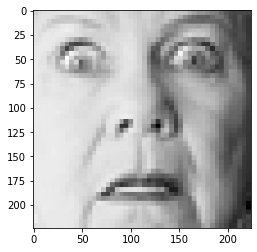

	>>>>>fear<<<<<<
surprise:   	14.911489188671112
fear:   	9.092666208744049
contempt:   	0.8193633519113064
disgust:   	3.845938667654991
anger:   	12.242275476455688
neutrality:   	17.014527320861816
sadness:   	14.47354108095169
happiness:   	27.60019600391388


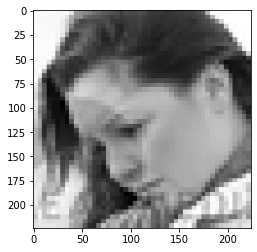

	>>>>>fear<<<<<<
surprise:   	19.87874060869217
fear:   	13.724379241466522
contempt:   	0.035309005761519074
disgust:   	1.2138299643993378
anger:   	9.70829576253891
neutrality:   	17.897577583789825
sadness:   	15.255776047706604
happiness:   	22.28608876466751


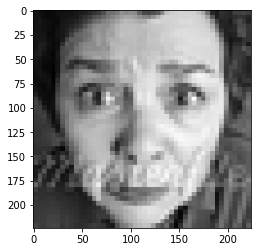

	>>>>>fear<<<<<<
surprise:   	13.721367716789246
fear:   	9.991110861301422
contempt:   	0.20608350168913603
disgust:   	2.0365575328469276
anger:   	10.455376654863358
neutrality:   	15.374736487865448
sadness:   	13.029727339744568
happiness:   	35.185036063194275


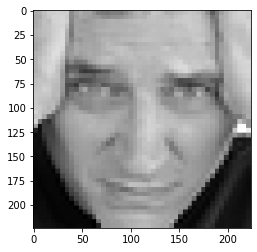

	>>>>>fear<<<<<<
surprise:   	7.031094282865524
fear:   	7.117337733507156
contempt:   	0.17512694466859102
disgust:   	1.8602065742015839
anger:   	12.13371455669403
neutrality:   	16.88486486673355
sadness:   	15.871070325374603
happiness:   	38.92658352851868


In [67]:
data="../raw_data/data_100/test"
emotion="fear"

suprise_poor = find_poor_images(model, emotion=emotion, data="../raw_data/data_100/test")

for im in suprise_poor:
    im = imageio.imread(f'{data}/{emotion}/{im}') / 255.0
    plt.imshow(im, cmap="gray")
    plt.show()
    print(f"\t>>>>>{emotion}<<<<<<")
    expand = np.expand_dims(np.expand_dims(im,axis=2), axis=0)
    pred = model.predict_proba(expand)
    for j in range(len(classes)):
        print(f"{classes[j]}:   \t{pred[0][j]*100}")
    